# HW5 SVM and Kernel Methods -- Part 2 Kernel Regression

In this part of HW5, you will solve a regression problem with kernel regression. It allows you to:

* gain experience with kernel regression, and
* perform model selection with hyperparameters in both a regression model  and its kernel.


## Import relevant packages

In [4]:
import numpy as np
import pandas as pd
import os

# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Load Training set data for the 'ByYear' split

In [5]:
# load the data
DATA_DIR = os.path.join("data_melbourne_daily_min_temp/") #TODO: fix it to your local file structure if necessary
data_trByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_train_ByYear.csv'))

# Inspect the first part of the data
data_trByYear_df.head()

,date,years_since_19850101,temp_deg_C
0,1981-01-01,-4.002740,20.7
1,1981-01-02,-4.000000,17.9
2,1981-01-03,-3.997260,18.8
3,1981-01-04,-3.994521,14.6
4,1981-01-05,-3.991781,15.8


In [6]:
# Inspect the last part of the data
data_trByYear_df.tail()

,date,years_since_19850101,temp_deg_C
2185,1986-12-27,1.986301,14.6
2186,1986-12-28,1.989041,14.2
2187,1986-12-29,1.991781,13.2
2188,1986-12-30,1.994521,11.7
2189,1986-12-31,1.997260,17.2


In [7]:
# Read relevant columns into numpy arrays for x and y. 
# NOTE: we only have 1 feature in this dataset. 

x_train = data_trByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_train = data_trByYear_df['temp_deg_C'].values[:].copy()

print("Training data (ByYear split strategy)")
print("x_train.shape: %s" % str(x_train.shape))
print("y_train.shape : %s" % str(y_train.shape))
print("mean(y_train) : %.3f" % np.mean(y_train))

Training data (ByYear split strategy)
x_train.shape: (2190, 1)
y_train.shape : (2190,)
mean(y_train) : 11.003


## Load Validation set data for the 'ByYear' split

In [8]:
data_vaByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_valid_ByYear.csv'))
data_vaByYear_df.head()

,date,years_since_19850101,temp_deg_C
0,1987-01-01,2.000000,12.3
1,1987-01-02,2.002740,13.8
2,1987-01-03,2.005479,15.3
3,1987-01-04,2.008219,15.6
4,1987-01-05,2.010959,16.2


In [9]:
x_valid = data_vaByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_valid = data_vaByYear_df['temp_deg_C'].values[:].copy()

print("Validation data (ByYear split strategy)")
print("x_valid.shape: %s" % str(x_valid.shape))
print("y_valid.shape : %s" % str(y_valid.shape))
print("mean(y_valid) : %.3f" % np.mean(y_valid))

Validation data (ByYear split strategy)
x_valid.shape: (730, 1)
y_valid.shape : (730,)
mean(y_valid) : 11.413


## Plot both training and validation sets

In the plot below, temperatures (labels) are plot against time (the only feature). This is a hard problem for many learning models that have no sense of the periodicity. 

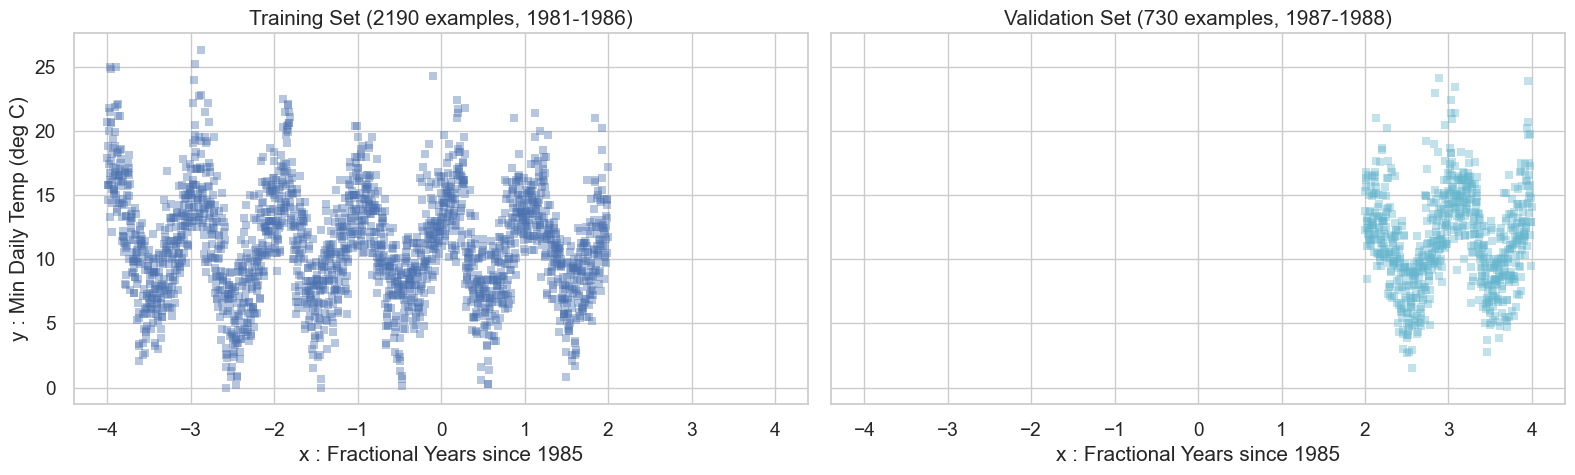

In [10]:
fig, axgrid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,5))

axgrid[0].plot(x_train, y_train, 'bs', alpha=0.4)
axgrid[0].set_xlabel('x : Fractional Years since 1985');
axgrid[0].set_title('Training Set (%d examples, %s-%s)' % (
    y_train.size,
    pd.to_datetime(data_trByYear_df['date'].values[0]).year,
    pd.to_datetime(data_trByYear_df['date'].values[-1]).year))

axgrid[1].plot(x_valid, y_valid, 'cs', alpha=0.4)
axgrid[1].set_xlabel('x : Fractional Years since 1985');
axgrid[1].set_title('Validation Set (%d examples, %s-%s)' % (
    y_valid.size,
    pd.to_datetime(data_vaByYear_df['date'].values[0]).year,
    pd.to_datetime(data_vaByYear_df['date'].values[-1]).year))

axgrid[0].set_ylabel("y : Min Daily Temp (deg C)");
plt.tight_layout();

## Prepare to use sklearn splitter tools for hyperparameter search

In [11]:
x_all = np.vstack([x_train, x_valid])
y_all = np.hstack([y_train, y_valid])

In [12]:
# Create splitter object using Predefined Split
import sklearn.model_selection

byyear_splitter = sklearn.model_selection.PredefinedSplit(np.hstack([
    -1 * np.ones(y_train.size), # -1 means never include this example in any 'test' split for grid search
    0  * np.ones(y_valid.size), #  0 means include in the first test split (we count starting at 0 in python)
    ]))

## Define utility function to make pretty plots of predictions for each model

In [13]:
def plot_data_and_predictions(model, model_legend_text='INSERT YOUR TEXT HERE'):
    plt.plot(x_train, y_train, 'bs', alpha=0.4, label='train data');
    plt.plot(x_valid, y_valid, 'cs', alpha=0.4, label='valid data');

    x_test_2 = [x_valid.min() + 2, x_valid.max() + 2]
    plt.fill_between(x_test_2, 0, 30, color='y', alpha=0.2, label='test period')

    L = 101
    xgrid_L1 = np.linspace(-5, 6, L).reshape((L,1))
    plt.plot(xgrid_L1, model.predict(xgrid_L1), 'r-', linewidth=3, label=model_legend_text);

    plt.ylim([-2, 28]);
    plt.xlabel('Fractional Years since 1985');
    plt.ylabel("Min Daily Temp (deg C)");
    plt.legend(bbox_to_anchor=(1.0, 0.5));



## Question 6 (5 points): Ridge Regression

**Question 6 (5 points)**: In this question, you need to fit a Ridge Regression model. In particular, you need to run model selection with `GridSearchCV`. NOTE that we aim to minimize the mean squared error, and the search should evalue models correspondingly. Once you have trained the best model, please generate a plot like the one below but using your best model. **In your report, please include best hyperparameter combination found and your generated plot**. 

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1; 1/5] START alpha=0.01..................................................
[CV 1/1; 1/5] END alpha=0.01;, score=(train=-104.684, test=-421.296) total time=   0.0s
[CV 1/1; 2/5] START alpha=0.1...................................................
[CV 1/1; 2/5] END alpha=0.1;, score=(train=-104.684, test=-421.292) total time=   0.0s
[CV 1/1; 3/5] START alpha=1.....................................................
[CV 1/1; 3/5] END alpha=1;, score=(train=-104.684, test=-421.255) total time=   0.0s
[CV 1/1; 4/5] START alpha=10....................................................
[CV 1/1; 4/5] END alpha=10;, score=(train=-104.684, test=-420.892) total time=   0.0s
[CV 1/1; 5/5] START alpha=100...................................................
[CV 1/1; 5/5] END alpha=100;, score=(train=-104.688, test=-417.303) total time=   0.0s
The best hyperparameter setting found is:
{'alpha': 100}


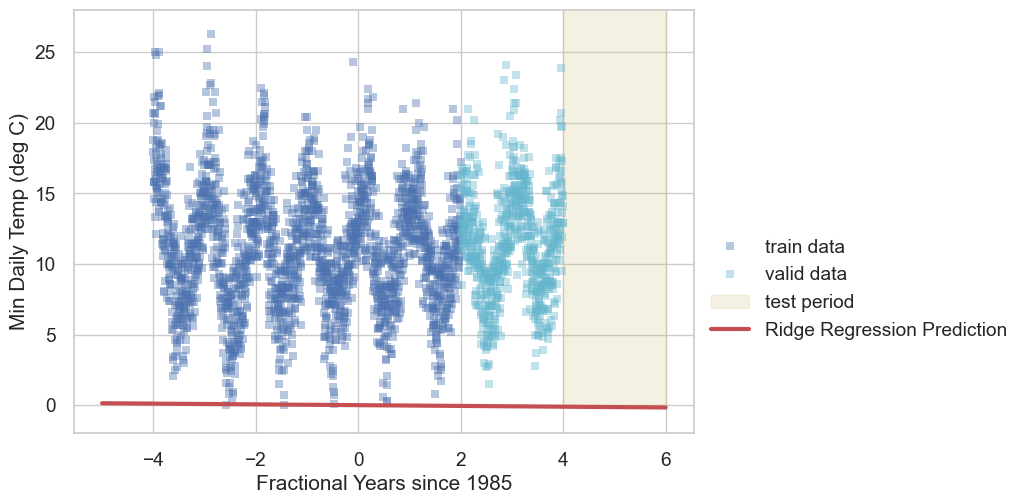

In [49]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import ExpSineSquared
import sklearn.metrics

# Recommended search range of alpha
alpha=[0.01, 0.1, 1, 10, 100]

kr = KernelRidge(alpha=1.0, kernel="linear")

# TODO: the following code is broken. Please fix the code to create a plot like the one below. 
# NOTE: It takes time to do the search. You can set `verbose=10` to monitor the progress.  
kr_linear_gs = sklearn.model_selection.GridSearchCV(
    kr, 
    param_grid= {'alpha': alpha},
    scoring= 'neg_mean_squared_error', # <https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter>
    cv=byyear_splitter,
    return_train_score=True,
    refit = True,
    verbose=10) 

kr_linear_gs.fit(x_all, y_all)

print("The best hyperparameter setting found is:")
print(kr_linear_gs.best_params_)

# Plot the best model
kr_linear_best = kr_linear_gs.best_estimator_
plot_data_and_predictions(kr_linear_best, 'Ridge Regression Prediction')

## Question 7 (5 points): Kernel Regression with the RBF Kernel

**Question 7 (5 points)**: In this question, you need to fit a Kernel Regression model with the RBF kernel. You need to run model selection with `GridSearchCV`. Again we aim to minimize the mean squared error, so please perform the search correspondingly. Once you have trained the best model, please generate a plot like the one above but using your best model. **In your report, please include best hyperparameter combination found and your generated plot**. 

Fitting 1 folds for each of 35 candidates, totalling 35 fits
[CV 1/1; 1/35] START alpha=0.01, kernel=RBF(length_scale=1).....................
[CV 1/1; 1/35] END alpha=0.01, kernel=RBF(length_scale=1);, score=(train=-14.564, test=-4482.979) total time=   0.1s
[CV 1/1; 2/35] START alpha=0.01, kernel=RBF(length_scale=2).....................
[CV 1/1; 2/35] END alpha=0.01, kernel=RBF(length_scale=2);, score=(train=-16.365, test=-101.968) total time=   0.1s
[CV 1/1; 3/35] START alpha=0.01, kernel=RBF(length_scale=4).....................
[CV 1/1; 3/35] END alpha=0.01, kernel=RBF(length_scale=4);, score=(train=-16.773, test=-14.775) total time=   0.1s
[CV 1/1; 4/35] START alpha=0.01, kernel=RBF(length_scale=8).....................
[CV 1/1; 4/35] END alpha=0.01, kernel=RBF(length_scale=8);, score=(train=-16.914, test=-27.332) total time=   0.1s
[CV 1/1; 5/35] START alpha=0.01, kernel=RBF(length_scale=16)....................
[CV 1/1; 5/35] END alpha=0.01, kernel=RBF(length_scale=16);, score=(tra

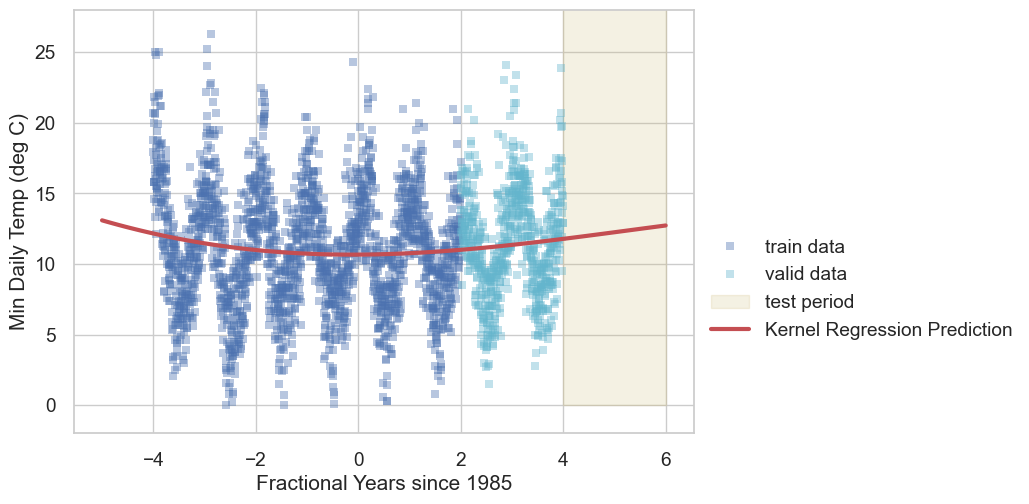

In [39]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process.kernels import RBF

# Recommended search range of alpha
alphas=[0.01, 0.1, 1, 10, 100]

# NOTE: RBF is implemented within kernel regression and has a parameter gamma. It can be tuned by just 
# specify a list of possible gamma values. However, this time I use an external kernel to 
# to show how we can tune any kernels. 

# NOTE: the implementation sklearn.gaussian_process.kernels.RBF uses `length_scale` to 
# parameterize an RBF kernel. It is equivalent to the gamma parameterization: 
# gamma = 1/(2 * length_scale^2)

length_scales = [1, 2, 4, 8, 16, 32, 64]
kernels = [RBF(length_scale) for length_scale in length_scales]


kr = KernelRidge(alpha=1.0, kernel="linear")

# TODO: the following code is broken. Please fix the code to create a plot like the one below. 
# NOTE: It takes time to do the search. You can set `verbose=10` to monitor the progress.  
kr_rbf_gs = sklearn.model_selection.GridSearchCV(
    kr, 
    param_grid=dict(alpha=alphas, kernel=kernels), # set the range of the hyperparameter search
    scoring="neg_mean_squared_error",
    cv=byyear_splitter,
    return_train_score=True,
    refit=True,
    verbose=10) 

kr_rbf_gs.fit(x_all, y_all)

print("The best hyperparameter setting found is:")
print(kr_rbf_gs.best_params_)

# Plot the best model
kr_rbf_best = kr_rbf_gs.best_estimator_
plot_data_and_predictions(kr_rbf_best, 'Kernel Regression Prediction')

## Question 8 (5 points): Kernel Regression with a Periodic Kernel

**Question 8 (5 points)**: In this question, you need to fit a Kernel Regression model with a periodic kernel. You need to select hyperparameters in the KR and the kernel via `GridSearchCV`. Again we aim to minimize the mean squared error, so please perform the search correspondingly. Once you have trained the best model, please generate a plot like the one above but using your best model. **In your report, please include best hyperparameter combination found and your generated plot**. 

In [52]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import ExpSineSquared

# Recommended search range of alpha
alpha=[0.01, 0.1, 1, 10, 100]

# TODO: please check the documentation of the ExpSineSquared kernel
# <https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html>
# There are two hyperparameters, length_scale and periodicity
# The length scale controls how much a data point focuses on its near neighbors. 
# The periodicity controls the frequency of similiarity along the distance. This 
# hyperparameter is critical to the performance of regression model on this dataset. 

# recommended hyperparameter range in the kernel. 
length_scales = [0.25, 0.5, 1, 2, 4]
periodicities = [0.1, 0.5, 1.0, 1.5, 2.0]

# TODO: please implement your own model tuning here. 
kernel=[ExpSineSquared(l,p) for l in length_scales for p in periodicities]

kr = KernelRidge()

# TODO: the following code is broken. Please fix the code to create a plot like the one below. 
# NOTE: It takes time to do the search. You can set `verbose=10` to monitor the progress.  
kr_ess_gs = sklearn.model_selection.GridSearchCV(
    kr, 
    param_grid= {'alpha': alpha, 'kernel':kernel},
    scoring= 'neg_mean_squared_error', # <https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter>
    cv=byyear_splitter,
    return_train_score=True,
    refit = True,
    verbose=10) 

kr_ess_gs.fit(x_all, y_all)


Fitting 1 folds for each of 125 candidates, totalling 125 fits
[CV 1/1; 1/125] START alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=0.1)
[CV 1/1; 1/125] END alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=0.1);, score=(train=-17.211, test=-14.155) total time=   0.2s
[CV 1/1; 2/125] START alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=0.5)
[CV 1/1; 2/125] END alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=0.5);, score=(train=-16.762, test=-14.658) total time=   0.2s
[CV 1/1; 3/125] START alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=1)
[CV 1/1; 3/125] END alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=1);, score=(train=-7.557, test=-8.439) total time=   0.2s
[CV 1/1; 4/125] START alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=1.5)
[CV 1/1; 4/125] END alpha=0.01, kernel=ExpSineSquared(length_scale=0.25, periodicity=1.5);, score=(train=-16.740, test=-14.011) total 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KernelRidge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'kernel': [ExpSineSquared(length_scale=0.25, periodicity=0.1),
                                    ExpSineSquared(length_scale=0.25, periodicity=0.5),
                                    ExpSineSquared(length_scale=0.25, periodicity=1),
                                    ExpSineSquared(length_scale=0.25, periodicity=1.5),
                                    ExpSineSquar...
                                    ExpSineSquared(length_scale=2, periodicity=1.5),
                                    ExpSineSquared(length_scale=2, periodicity=2),
                                    ExpSineSquared(length_scale=4, periodicity=0.1),
                                    ExpSineSquared(length_scale=4, periodicity=0.5),
                                    ExpSineSquared(length_scale=4, periodicity=1),
                                    ExpSineSquared(length_scale=4, periodicity=1.5),
                                    ExpSineSquared(length_scale=4, periodicity=2)]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

The best hyperparameter setting found is:
{'alpha': 10, 'kernel': ExpSineSquared(length_scale=4, periodicity=1)}


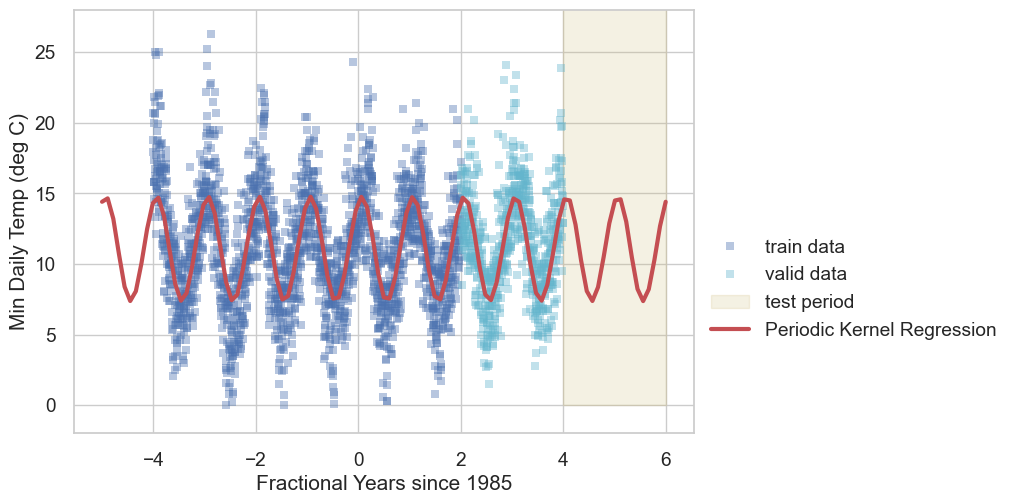

In [55]:
print("The best hyperparameter setting found is:")
print(kr_ess_gs.best_params_)

# Plot the best model
kr_ess_best = kr_ess_gs.best_estimator_
plot_data_and_predictions(kr_ess_best, 'Periodic Kernel Regression')

## Question 9 (5 points): Compare Performance of Different Models

**Question 9 (5 points)**: In this question, you need to test the three regression models on the training, validation, and test sets and report their performances in a table. 


In [57]:
# Load the test set

data_te_df = pd.read_csv(os.path.join(DATA_DIR, 'data_test_ByYear.csv'))

x_test = data_te_df['years_since_19850101'].values[:][:,np.newaxis].copy()  # Load (T,1) feature values array
y_test = data_te_df['temp_deg_C'].values[:].copy()                           # Load (T,) feature values array

data_te_df.head()

,date,years_since_19850101,temp_deg_C
0,1989-01-01,4.00,14.3
1,1989-01-02,4.01,17.4
2,1989-01-03,4.01,18.5
3,1989-01-04,4.01,16.8
4,1989-01-05,4.01,11.5


In [63]:
from sklearn.metrics import mean_squared_error

# TOOD: Please test the three regression models on the training, validation, and test sets 
# and show their performances in the table below. 

# Calculate RMSE for each regression model on the training, validation, and test sets
train_rmse_linear = np.sqrt(mean_squared_error(y_train, kr_linear_best.predict(x_train)))
val_rmse_linear = np.sqrt(mean_squared_error(y_valid, kr_linear_best.predict(x_valid)))
test_rmse_linear = np.sqrt(mean_squared_error(y_test, kr_linear_best.predict(x_test)))

train_rmse_rbf = np.sqrt(mean_squared_error(y_train, kr_rbf_best.predict(x_train)))
val_rmse_rbf = np.sqrt(mean_squared_error(y_valid, kr_rbf_best.predict(x_valid)))
test_rmse_rbf = np.sqrt(mean_squared_error(y_test, kr_rbf_best.predict(x_test)))

train_rmse_exp_sine_squared = np.sqrt(mean_squared_error(y_train, kr_ess_best.predict(x_train)))
val_rmse_exp_sine_squared = np.sqrt(mean_squared_error(y_valid, kr_ess_best.predict(x_valid)))
test_rmse_exp_sine_squared = np.sqrt(mean_squared_error(y_test, kr_ess_best.predict(x_test)))

# Fill in the table
pd.set_option('display.precision', 2)
tab_df = pd.DataFrame({
    "method": ["linear", "RBF", "ExpSineSquared"], 
    "train RMSE": [train_rmse_linear, train_rmse_rbf, train_rmse_exp_sine_squared], 
    "validation RMSE": [val_rmse_linear, val_rmse_rbf, val_rmse_exp_sine_squared], 
    "test RMSE": [test_rmse_linear, test_rmse_rbf, test_rmse_exp_sine_squared]
})

In [64]:
tab_df # Pretty print to this notebook

,method,train RMSE,validation RMSE,test RMSE
0,linear,11.74,12.08,12.31
1,RBF,4.14,3.72,4.22
2,ExpSineSquared,2.86,2.75,2.64
